In [11]:
### PYMOO
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.util.display.multi import MultiObjectiveOutput
from pymoo.core.sampling import Sampling
from pymoo.core.mutation import Mutation
from pymoo.indicators.hv import HV

from custom_display import MultiObjectiveOutputCustom

#multiprocessamento e pymoo
import os
import multiprocessing
from pymoo.core.problem import StarmapParallelization

#Pandas, SKLearn e etc.
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import plotly.express as px
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pickle

#filtros
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#Goatools e Gontosim
from goatools.obo_parser import GODag
from goatools.base import get_godag
import pandas as pd
import requests, sys
import time
import itertools
import dill
import random
from tqdm.notebook import tqdm

#go = get_godag("go-basic.obo", optional_attrs={'relationship'})

from Similarity import Similarity_of_Two_GOTerms, Similarity_of_Set_of_GOTerms
import pickle

In [2]:
data = pd.read_pickle('Data/data_normalized.pkl')

In [3]:
colunas = list(data.columns)
colunas.remove('samples')
colunas.remove('type')

affymetrix_GO_terms_dict = dict(zip(pd.read_pickle('Data/affymetrix_GO_terms_dict.pkl')['ID'],pd.read_pickle('Data/affymetrix_GO_terms_dict.pkl')['GO term']))

X = data[colunas]
y = data['type']

matrix_similarity = np.load('Data/matrix_go_terms_sets.npy')
with open('Data/go_terms_sets_labels.pkl', 'rb') as file:
    go_sets_labels = pickle.load(file)

In [4]:
with open('Data/scores_affymetrix_vs_liver_cancer.pkl', 'rb') as file:
    scores_affymetrix_vs_liver_cancer = pickle.load(file)

Funções de Avaliação

In [5]:
def _init_evaluator():
    global pid_, X_worker, y_worker, colunas_worker
    pid_ = os.getpid()
    X_worker = np.array(X.copy())
    y_worker = np.array(y.copy())
    colunas_worker = colunas.copy()
    print(pid_)
def _init_mutator():
    global pid_, colunas_worker, matrix_similarity_worker, go_sets_labels_worker
    pid_ = os.getpid()
    colunas_worker = colunas.copy()
    matrix_similarity_worker = matrix_similarity.copy()
    go_sets_labels_worker = go_sets_labels.copy()

In [6]:
class GeneSelection(ElementwiseProblem):
    def __init__(self, X, y, runner):
        #self.X = X_worker
        #self.y = y_worker
        self.n_features = X.shape[1]
        self.eval_dict = {'n_features':[], 'f1_score':[]}
        super().__init__(   n_var=self.n_features,
    						n_obj=2,
    						n_constr=0,
    						xl=np.zeros(self.n_features),
    						xu=np.ones(self.n_features),
    						elementwise_evaluation=True,
                            type_var=bool,
                            save_history=True,
                            elementwise_runner=runner)

    def _evaluate(self, x, out, *args, **kwargs):
    	# seleciona as features de acordo com o vetor binário
        #start = time.time()
        selected_features = np.where(x == 1)[-1]
        X_selected = X_worker[:,selected_features]
        f_1 = []
        n_tests = 5
        for i in range(n_tests):
            seed = 42
            # Kfolding usado para separar em treino e teste
            skf = StratifiedKFold(n_splits=10, random_state=seed + 1, shuffle=True)
            #X_train, X_valid, y_train, y_valid = train_test_split(X_selected, self.y, test_size=0.1, random_state=100)
        	
        	# treino usando modelo SVM
            clf = svm.SVC(kernel='linear')
    
            # compute f_1 and AUC on validation set
            f_1.append(np.mean(cross_val_score(clf, X_selected, y_worker, cv=skf, scoring='f1_macro')))
        
        f_1 = np.array(f_1).sum()/n_tests
        n_features = len(selected_features)
        # salvar os resultados
        self.eval_dict['n_features'].append(n_features)
        self.eval_dict['f1_score'].append(f_1)
        #print("tempo eval:", time.time() - start)
    	# define os objetivos a serem minimizados
        out["F"] = [n_features, -f_1]


In [7]:
MAX_FEATURES = 100
class BinaryDistributedRandomSampling(Sampling):

    def _do(self, problem, n_samples, **kwargs):
        population = []
        for i in range(n_samples):
            trues = np.random.randint(1, MAX_FEATURES + 1)
            individual = np.array([True] * trues + [False] * (problem.n_var - trues))
            np.random.shuffle(individual)
            population.append(individual)
        #print(population)
        population = np.array(population)
        row_sums = population.sum(axis=1)
        # Mostra a matriz ordenada
        print(sorted(row_sums))
        return population

class BinaryDistributedRandomSamplingFilter(Sampling):

    def _do(self, problem, n_samples, **kwargs):
        population = []
        filter = SelectKBest(f_classif, k=1000).fit(X, y)
        features_filter = filter.get_feature_names_out()
        possible_indexes = [colunas.index(item) for item in features_filter]
        print(possible_indexes)
        for i in range(n_samples):
            trues = np.random.randint(1, MAX_FEATURES + 1)
            indexes = np.random.choice(possible_indexes, trues, replace=False)
            individual = np.full(problem.n_var, False)
            individual[indexes] = True
            population.append(individual)
            #print(trues)
            #print(sorted(indexes))
            #print(individual)
        #print(population)
        population = np.array(population)
        row_sums = population.sum(axis=1)
        # Mostra a matriz ordenada
        print(sorted(row_sums))
        return population


class BitflipMutationLimited(Mutation):

    def _do(self, problem, X, **kwargs):
        prob_var = self.get_prob_var(problem, size=(len(X), 1))
        Xp = np.copy(X)
        flip = np.random.random(X.shape) < prob_var
        Xp[flip] = ~X[flip]
        
        for individual in Xp:
            if individual.sum() == 0:
                individual[np.random.choice(range(len(individual)))] = True
            while individual.sum() > MAX_FEATURES:
                individual[np.random.choice(range(len(individual)))] = False
        return Xp
'''
def return_score(gen1, gen2):
    if len(gen1) == 0 or len(gen2) == 0:
        return 0
    if len(gen1) > 100:
        gen1 = np.random.choice(gen1, 100)
    if len(gen2) > 10:
        gen2 = np.random.choice(gen2, 10)
    return Similarity_of_Set_of_GOTerms(gen1, gen2, 'GOGO')
'''
def get_Similarity_of_Affymetrix(aff1, aff2, affymetryx_to_go, matrix_similarity, go_sets_labels):
    gen1 = []
    gen2 = []
    for aff in aff1:
        gen1.append(affymetrix_GO_terms_dict[aff])

    gen2 = affymetrix_GO_terms_dict[aff2]
    score = 0
    for gen_subset in gen1:
            score += get_Similarity_of_Set_of_GOTerms(gen_subset, gen2, matrix_similarity, go_sets_labels)/len(gen1)
    return score

def get_Similarity_of_Set_of_GOTerms(gen1, gen2, matrix_similarity, labels):
    return matrix_similarity[labels[tuple(gen1)]][[labels[tuple(gen2)]]][0]
    
def mutate_individual(individual, past_individual, n_mutations):
    added = individual & ~past_individual
    total_added = added.sum()
    individual[added] = False
    affymetrix_individual = np.array(colunas_worker)[individual]
    
    for i in range(added.sum()):
        max_score = 0
        for i in range(n_mutations):
            candidate = np.random.choice(np.array(range(len(individual)))[~individual])
            final_candidate = candidate
            affymetrix_candidate = colunas_worker[candidate]
            score = get_Similarity_of_Affymetrix(affymetrix_individual, affymetrix_candidate, affymetrix_GO_terms_dict, matrix_similarity_worker, go_sets_labels_worker)
            if max_score < score:
                final_candidate = candidate
                max_score = score
        
        individual[final_candidate] = True  
    return individual

def mutate_individual_fuzzy(individual, past_individual, n_mutations, exploratory):
    added = individual & ~past_individual
    total_added = added.sum()
    individual[added] = False
    affymetrix_individual = np.array(colunas_worker)[individual]
    
    for i in range(added.sum()):
        candidates = []
        candidates_scores = []
        for i in range(n_mutations):
            candidate = np.random.choice(np.array(range(len(individual)))[~individual])
            candidates.append(candidate)
            affymetrix_candidate = colunas_worker[candidate]
            score = get_Similarity_of_Affymetrix(affymetrix_individual, affymetrix_candidate, affymetrix_GO_terms_dict, matrix_similarity_worker, go_sets_labels_worker)
            candidates_scores.append(score)
            
        candidates_scores = np.array(candidates_scores) + 0.01
        if exploratory:
            candidates_scores = [1 for score in candidates_scores]
        #print(candidates_scores)
        final_candidate = random.choices(candidates, weights=candidates_scores, k=1)
        individual[final_candidate] = True  
    return individual

def mutate_individual_fuzzy_pathways(individual, past_individual, n_mutations, exploratory):
    added = individual & ~past_individual
    total_added = added.sum()
    individual[added] = False
    affymetrix_individual = np.array(colunas_worker)[individual]
    
    for i in range(added.sum()):
        candidates = []
        candidates_scores = []
        for i in range(n_mutations):
            candidate = np.random.choice(np.array(range(len(individual)))[~individual])
            candidates.append(candidate)
            score = scores_affymetrix_vs_liver_cancer[candidate]
            candidates_scores.append(score)
            
        candidates_scores = np.array(candidates_scores) + 0.01
        #if exploratory:
        #    candidates_scores = [1 for score in candidates_scores]
        #print(candidates_scores)
        final_candidate = random.choices(candidates, weights=candidates_scores, k=1)
        individual[final_candidate] = True  
    return individual

class BitflipMutationLimitedGuided(Mutation):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)
        self.steps = 0

    def _do(self, problem, X, **kwargs):
        self.steps += 1
        #print(self.steps)
        prob_var = self.get_prob_var(problem, size=(len(X), 1))
        Xp = np.copy(X)
        flip = np.random.random(X.shape) < prob_var
        Xp[flip] = ~X[flip]

        algorithm = kwargs['algorithm']
        #if algorithm.n_gen > (algorithm.termination.n_max_gen/2):
            #print('aahh')
            #Xp = np.array([mutate_individual(xi[0], xi[1]) for xi in zip(Xp, X)])
        exploratory = random.choice([False, True])
        Xp = np.array(mutation_pool.starmap(mutate_individual_fuzzy_pathways, zip(Xp, X, itertools.repeat(20), itertools.repeat(exploratory))))
            #print('Tempo:', time.time() - start)        
            #for individual, past_individual in zip (Xp, X):
            #    individual = mutate_individual(individual, past_individual)
                
        for individual in Xp:
            if individual.sum() == 0:
                individual[np.random.choice(range(len(individual)))] = True
            while individual.sum() > MAX_FEATURES:
                individual[np.random.choice(range(len(individual)))] = False
        return Xp


In [8]:
# initialize the thread pool and create the runner
n_proccess = 48
pool = multiprocessing.Pool(n_proccess, initializer=_init_evaluator)
runner = StarmapParallelization(pool.starmap)
pool_ = multiprocessing.Pool(n_proccess, initializer=_init_evaluator)
runner_ = StarmapParallelization(pool_.starmap)
mutation_pool = multiprocessing.Pool(n_proccess, initializer=_init_mutator)

3138831394

31392
31398
3138931390
31391

31400
3138331397

31404
313853138631396


31387
31395
314033140631393


3140831402

3140531412

31411
31399
31407
3141431416

3141931401

3143331409

3141031418

3142431422

31413
31426
314283142031440


3141731423

31415
31451
31421
31470
31465
31427
3142531445

3152231456

31508
31543
31475
3148231503
31557
31500

3156631532

31585
31550
3153731563314913151531575




31527
3161131546

31594
31549
31650
31560
316043158031599


31626
31661
31658
3161631664

31637
31643
3168531655

31684
31678
31668
3167131683

31697
31690
31702


In [9]:
problem = GeneSelection(X,y.values, runner)
algorithm = NSGA2(pop_size=10,
				  sampling=BinaryDistributedRandomSampling(),
				  crossover=TwoPointCrossover(),
				  mutation=BitflipMutationLimitedGuided(),
                  #display = MultiObjectiveOutputCustom(),
                  save_history = True)

In [10]:
start = time.time()
res = minimize(problem,  # problem class
			    algorithm,  # NSGA2 algorithm
                ("n_gen", 50), # number of iteration for eval problem class
			    verbose=True)
print(time.time() - start)

[17, 19, 22, 40, 50, 56, 70, 72, 81, 81]
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       10 |      3 |             - |             -
     2 |       20 |      4 |  0.4350776232 |         ideal
     3 |       30 |      3 |  0.3026459214 |         ideal
     4 |       40 |      7 |  0.0588235294 |         nadir
     5 |       50 |      7 |  0.0707555354 |             f
     6 |       60 |      7 |  0.000000E+00 |             f
     7 |       70 |      5 |  4.0940796380 |         nadir
     8 |       80 |      3 |  0.3219391395 |         ideal
     9 |       90 |      5 |  0.0166451593 |         ideal
    10 |      100 |      3 |  0.4086819974 |         ideal
    11 |      110 |      3 |  0.0694245601 |             f
    12 |      120 |      3 |  0.4390373556 |         ideal
    13 |      130 |      2 |  0.3333333333 |         ideal
    14 |      140 |      3 |  0.2585704922 |         ideal
    15 |      150 |      3 |  0.9604969013 |         nadir
    16 |      1

In [11]:
res.exec_time

22.888195753097534

0.9671543097860976

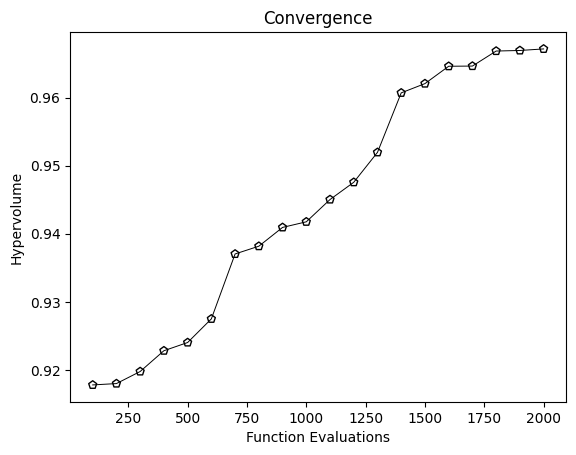

In [15]:
n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])
    
X_res, F_res = res.opt.get("X", "F")
    
hist = res.history
max = 100
ref_point = np.array([max, 0])
ind = HV(ref_point=ref_point)
    
n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population
    
for algo in hist:
    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)
    
    # retrieve the optimum from the algorithm
    opt = algo.opt
    
    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())
    
    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

metric = HV(ref_point= np.array([max, 0]),
                         norm_ref_point=False)

hv = [metric.do(_F)/max for _F in hist_F]

    #plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
hv[-1]

In [ ]:
result_stock = []
algorithm = NSGA2(pop_size=400,
				  sampling=BinaryDistributedRandomSamplingFilter(),
				  crossover=TwoPointCrossover(),
				  mutation=BitflipMutationLimited(),
                  save_history = True)

for i in range(5):
    result_stock.append( 
        minimize(problem,  # problem class
			    algorithm,  # NSGA2 algorithm
                ("n_gen", 200), # number of iteration for eval problem class
			    verbose=True))


############################################################################
result_modified = []
algorithm = NSGA2(pop_size=400,
				  sampling=BinaryDistributedRandomSamplingFilter(),
				  crossover=TwoPointCrossover(),
				  mutation=BitflipMutationLimitedGuided(),
                  save_history = True)

for i in range(5):
    result_modified.append(
        minimize(problem,  # problem class
			    algorithm,  # NSGA2 algorithm
                ("n_gen", 200), # number of iteration for eval problem class
			    verbose=True))
    

[12, 25, 27, 40, 41, 45, 48, 57, 72, 77, 82, 84, 85, 88, 115, 120, 121, 135, 141, 154, 166, 179, 188, 230, 235, 237, 240, 262, 277, 284, 290, 292, 297, 298, 310, 314, 315, 319, 344, 353, 356, 357, 361, 364, 369, 370, 380, 390, 400, 402, 404, 409, 416, 418, 437, 459, 470, 471, 476, 484, 487, 515, 526, 568, 595, 601, 604, 615, 617, 619, 638, 639, 654, 655, 662, 704, 726, 728, 729, 779, 787, 793, 795, 802, 816, 818, 819, 820, 830, 853, 854, 869, 874, 904, 905, 908, 917, 932, 933, 952, 980, 984, 985, 986, 999, 1004, 1006, 1012, 1013, 1035, 1042, 1043, 1045, 1051, 1054, 1058, 1082, 1092, 1104, 1105, 1111, 1114, 1117, 1121, 1135, 1183, 1190, 1191, 1208, 1220, 1221, 1241, 1258, 1270, 1282, 1291, 1298, 1322, 1368, 1384, 1401, 1417, 1420, 1424, 1457, 1471, 1474, 1483, 1500, 1512, 1530, 1547, 1552, 1554, 1556, 1568, 1608, 1622, 1634, 1671, 1672, 1680, 1695, 1711, 1727, 1744, 1747, 1750, 1770, 1771, 1773, 1788, 1803, 1833, 1836, 1848, 1851, 1853, 1872, 1893, 1922, 1940, 1947, 1949, 1996, 2002, 20

0.7128460932647975
0.7104998275104597


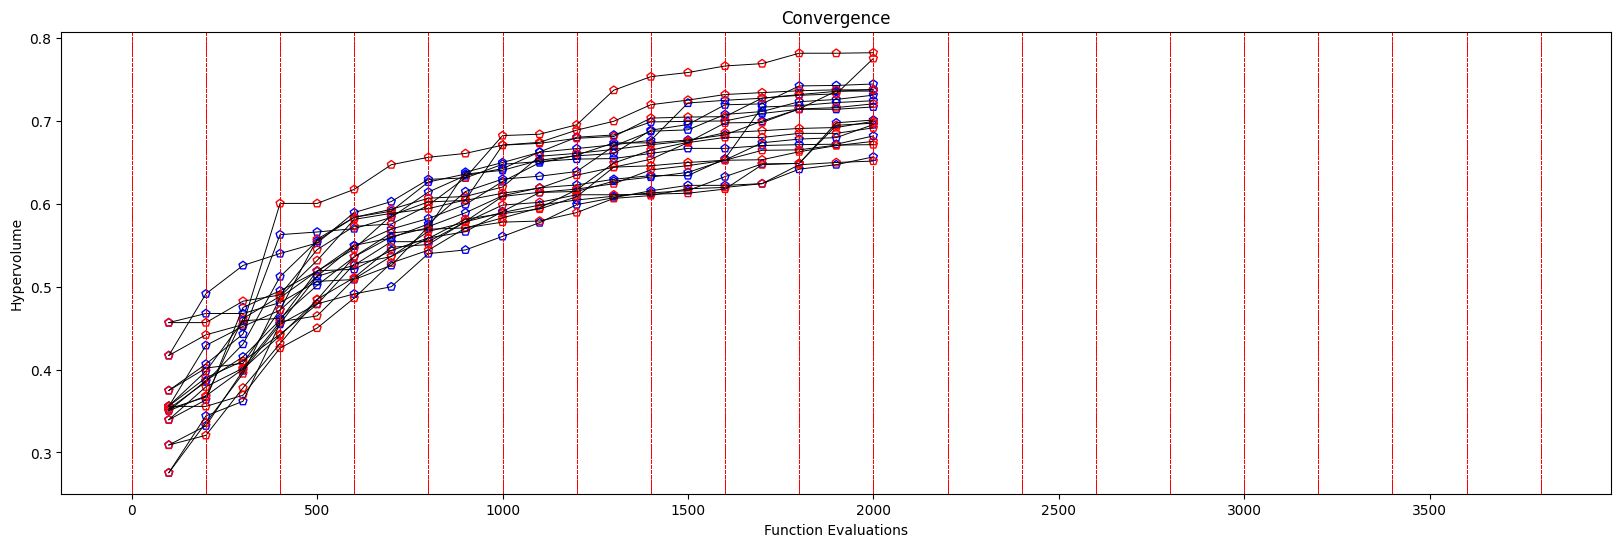

In [13]:
def plot_convergence(res, color):
    n_evals = np.array([e.evaluator.n_eval for e in res.history])
    opt = np.array([e.opt[0].F for e in res.history])
    
    X_res, F_res = res.opt.get("X", "F")
    
    hist = res.history
    max = 50
    ref_point = np.array([max, -0.90])
    ind = HV(ref_point=ref_point)
    
    n_evals = []             # corresponding number of function evaluations\
    hist_F = []              # the objective space values in each generation
    hist_cv = []             # constraint violation in each generation
    hist_cv_avg = []         # average constraint violation in the whole population
    
    for algo in hist:
        # store the number of function evaluations
        n_evals.append(algo.evaluator.n_eval)
    
        # retrieve the optimum from the algorithm
        opt = algo.opt
    
        # store the least contraint violation and the average in each population
        hist_cv.append(opt.get("CV").min())
        hist_cv_avg.append(algo.pop.get("CV").mean())
    
        # filter out only the feasible and append and objective space values
        feas = np.where(opt.get("feasible"))[0]
        hist_F.append(opt.get("F")[feas])

    metric = HV(ref_point= ref_point,
                         norm_ref_point=False)

    hv = [metric.do(_F)/5 for _F in hist_F]

    plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
    plt.scatter(n_evals, hv,  facecolor="none", edgecolor=color, marker="p", linewidths=1)
    plt.title("Convergence")
    plt.xlabel("Function Evaluations")
    plt.ylabel("Hypervolume")
    for i in range(20):
        
        plt.axvline(x=200*i, color='r', linestyle='--', linewidth=0.7)
    #plt.xscale(value = 'log')
    #plt.show()
    return ind(F_res)/5
plt.figure(figsize=(20,6))

media_stock = []
for res in result_stock:
    media_stock.append(plot_convergence(res, 'blue'))

#plt.figure(figsize=(20,6))
print(np.array(media_stock).sum()/len(result_stock))

media_modified = []
for res in result_modified:
    media_modified.append(plot_convergence(res, 'red'))


print(np.array(media_modified).sum()/len(result_stock))


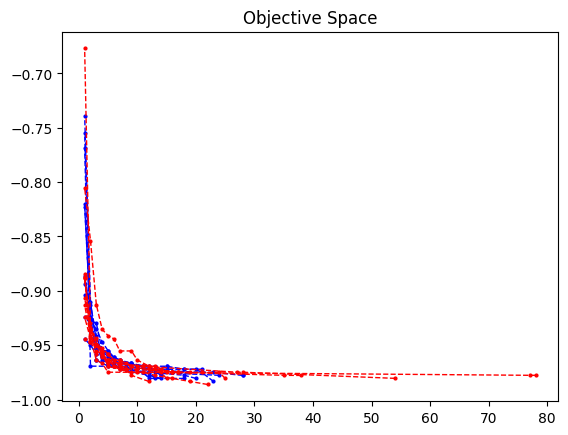

In [14]:
def plot_pareto_front(res, color):
    #plt.figure(figsize=(7, 5))
    X_res, F_res = res.opt.get("X", "F")
    plt.plot(F_res[:, 0][np.argsort(F_res[:, 1])], F_res[:, 1][np.argsort(F_res[:, 1])], color = color,  marker='o', mfc=color, mec=color, ms=2, ls='--', lw=1, zorder=2)
    plt.title("Objective Space")
for i in result_stock:
    plot_pareto_front(i, 'blue')

for i in result_modified:
    plot_pareto_front(i, 'red')


In [67]:
for i in result_modified[0].X:
    for j in np.array(colunas)[i]:
        print("'" + str(j).replace("[",'').replace("'", '').replace(",",'').replace("]",'') + "',")
    print('----------------------')

'204428_s_at',
----------------------
'203385_at',
'204428_s_at',
'210163_at',
'211699_x_at',
'220035_at',
----------------------
'202221_s_at',
'203848_at',
'203854_at',
'203867_s_at',
'203907_s_at',
'204093_at',
'204141_at',
'204558_at',
'206601_s_at',
'207617_at',
'208180_s_at',
'208443_x_at',
'208625_s_at',
'208743_s_at',
'208760_at',
'208932_at',
'209116_x_at',
'209722_s_at',
'210773_s_at',
'211670_x_at',
'211993_at',
'212045_at',
'212082_s_at',
'212178_s_at',
'212384_at',
'212517_at',
'212547_at',
'212637_s_at',
'212938_at',
'213470_s_at',
'213495_s_at',
'213562_s_at',
'213623_at',
'217775_s_at',
'218037_at',
'218211_s_at',
'218276_s_at',
'218952_at',
'219012_s_at',
'219115_s_at',
'219189_at',
----------------------
'203385_at',
'204428_s_at',
'206453_s_at',
----------------------
'202221_s_at',
'203848_at',
'203854_at',
'203867_s_at',
'203907_s_at',
'204093_at',
'204141_at',
'204558_at',
'207617_at',
'208180_s_at',
'208443_x_at',
'208625_s_at',
'208743_s_at',
'208760_at',
'20893

In [27]:
X_np = np.array(X)
start = time.time()

for i in range(1,100):
    selected_features = np.random.randint(low=0, high=22000, size=i)
    X_selected = X_np[:,selected_features]
    seed = 42
    # Kfolding usado para separar em treino e teste
    skf = StratifiedKFold(n_splits=10, random_state=seed + 1, shuffle=True)
    #X_train, X_valid, y_train, y_valid = train_test_split(X_selected, self.y, test_size=0.1, random_state=100)    	
    # treino usando modelo SVM
    clf = svm.SVC(kernel='linear')
    np.mean(cross_val_score(clf, X_selected, y, cv=skf, scoring='f1_macro'))
    print(time.time() - start)

0.06769609451293945
0.1348869800567627
0.20936131477355957
0.2736215591430664
0.33510828018188477
0.40218138694763184
0.469714879989624
0.5328636169433594
0.5959246158599854
0.6689722537994385
0.7399992942810059
0.8374288082122803
0.9450201988220215
1.0294499397277832
1.1237726211547852
1.2002403736114502
1.286712884902954
1.3862831592559814
1.454277515411377
1.5644233226776123
1.6685752868652344
1.7486889362335205
1.8332056999206543
1.9191532135009766
2.010741949081421
2.109636068344116
2.1975550651550293
2.3199989795684814
2.4059362411499023
2.4904844760894775
2.5655956268310547
2.6478748321533203
2.7490484714508057
2.863018751144409
2.962693452835083
3.05728816986084
3.1304357051849365
3.2072813510894775
3.283470869064331
3.36495041847229
3.469653367996216
3.5527467727661133
3.6502082347869873
3.7534589767456055
3.843282699584961
3.9380886554718018
4.054921865463257
4.149556398391724
4.220421552658081
4.298423528671265
4.3831470012664795
4.457686185836792
4.554025173187256
4.6485209

In [55]:
for k in range(5):
    algorithm.next()
    print(algorithm.n_gen)

    with open('checkpoint', 'wb') as f:
        pickle.dump(algorithm, f)


with open('checkpoint', 'rb') as f:
    checkpoint = pickle.load(f)
    checkpoint.mutation = BitflipMutationLimitedGuided()
    checkpoint.setup(problem, seed=1, termination=('n_gen', 20))
    print("Loaded Checkpoint:", checkpoint)

for k in range(5):
    checkpoint.next()
    print(checkpoint.n_gen)

[12, 25, 27, 40, 41, 45, 48, 57, 72, 77, 82, 84, 85, 88, 115, 120, 121, 135, 141, 154, 166, 179, 188, 230, 235, 237, 240, 262, 277, 284, 290, 292, 297, 298, 310, 314, 315, 319, 344, 353, 356, 357, 361, 364, 369, 370, 380, 390, 400, 402, 404, 409, 416, 418, 437, 459, 470, 471, 476, 484, 487, 515, 526, 568, 595, 601, 604, 615, 617, 619, 638, 639, 654, 655, 662, 704, 726, 728, 729, 779, 787, 793, 795, 802, 816, 818, 819, 820, 830, 853, 854, 869, 874, 904, 905, 908, 917, 932, 933, 952, 980, 984, 985, 986, 999, 1004, 1006, 1012, 1013, 1035, 1042, 1043, 1045, 1051, 1054, 1058, 1082, 1092, 1104, 1105, 1111, 1114, 1117, 1121, 1135, 1183, 1190, 1191, 1208, 1220, 1221, 1241, 1258, 1270, 1282, 1291, 1298, 1322, 1368, 1384, 1401, 1417, 1420, 1424, 1457, 1471, 1474, 1483, 1500, 1512, 1530, 1547, 1552, 1554, 1556, 1568, 1608, 1622, 1634, 1671, 1672, 1680, 1695, 1711, 1727, 1744, 1747, 1750, 1770, 1771, 1773, 1788, 1803, 1833, 1836, 1848, 1851, 1853, 1872, 1893, 1922, 1940, 1947, 1949, 1996, 2002, 20

In [57]:
algorithm

In [35]:
from pymoo.termination.max_gen import MaximumGenerationTermination
from pymoo.termination import get_termination
import copy

algorithm = NSGA2(pop_size=100,
				  sampling=BinaryDistributedRandomSamplingFilter(),
				  crossover=TwoPointCrossover(),
				  mutation=BitflipMutationLimited(),
                  save_history = True)

start = time.time()
res = minimize(problem,  # problem class
			    algorithm,  # NSGA2 algorithm
                ("n_gen", 2), # number of iteration for eval problem class
			    copy_algorithm=False,
                verbose=True)
print(time.time() - start)

# only necessary if for the checkpoint the termination criterion has been met

res_copy = copy.deepcopy(res)


problem_ = GeneSelection(X,y.values, runner_)

checkpoint = res_copy.algorithm
checkpoint.problem = problem_
algorithm.termination = MaximumGenerationTermination(5)
checkpoint.termination = MaximumGenerationTermination(5)

res = minimize(problem_,
               checkpoint,
               ("n_gen", 4),
               copy_algorithm=False,
               verbose=True,
               save_history = True)

res_ = minimize(problem,
               algorithm,
               ("n_gen", 4),
               copy_algorithm=False,
               verbose=True,
               save_history = True)

[12, 25, 27, 40, 41, 45, 48, 57, 72, 77, 82, 84, 85, 88, 115, 120, 121, 135, 141, 154, 166, 179, 188, 230, 235, 237, 240, 262, 277, 284, 290, 292, 297, 298, 310, 314, 315, 319, 344, 353, 356, 357, 361, 364, 369, 370, 380, 390, 400, 402, 404, 409, 416, 418, 437, 459, 470, 471, 476, 484, 487, 515, 526, 568, 595, 601, 604, 615, 617, 619, 638, 639, 654, 655, 662, 704, 726, 728, 729, 779, 787, 793, 795, 802, 816, 818, 819, 820, 830, 853, 854, 869, 874, 904, 905, 908, 917, 932, 933, 952, 980, 984, 985, 986, 999, 1004, 1006, 1012, 1013, 1035, 1042, 1043, 1045, 1051, 1054, 1058, 1082, 1092, 1104, 1105, 1111, 1114, 1117, 1121, 1135, 1183, 1190, 1191, 1208, 1220, 1221, 1241, 1258, 1270, 1282, 1291, 1298, 1322, 1368, 1384, 1401, 1417, 1420, 1424, 1457, 1471, 1474, 1483, 1500, 1512, 1530, 1547, 1552, 1554, 1556, 1568, 1608, 1622, 1634, 1671, 1672, 1680, 1695, 1711, 1727, 1744, 1747, 1750, 1770, 1771, 1773, 1788, 1803, 1833, 1836, 1848, 1851, 1853, 1872, 1893, 1922, 1940, 1947, 1949, 1996, 2002, 20

0.9659504882518815

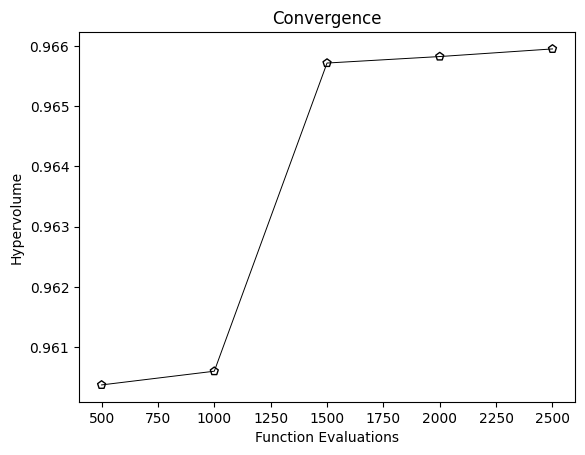

In [39]:
n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])
    
X_res, F_res = res_.opt.get("X", "F")
    
hist = res_.history
max = 100
ref_point = np.array([max, 0])
ind = HV(ref_point=ref_point)
    
n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population
    
for algo in hist:
    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)
    
    # retrieve the optimum from the algorithm
    opt = algo.opt
    
    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())
    
    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

metric = HV(ref_point= np.array([max, 0]),
                         norm_ref_point=False)

hv = [metric.do(_F)/max for _F in hist_F]

    #plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
hv[-1]

In [12]:
from pymoo.termination.max_gen import MaximumGenerationTermination
from pymoo.termination import get_termination
import copy


result_stock = []
result_modified = []



for i in tqdm(range(10)):
    algorithm = NSGA2(pop_size=100,
				  sampling=BinaryDistributedRandomSampling(),
				  crossover=TwoPointCrossover(),
				  mutation=BitflipMutationLimited(),
                  save_history = True)
    
    res = minimize(problem,  # problem class
			    algorithm,  # NSGA2 algorithm
                ("n_gen", 1), # number of iteration for eval problem class
			    copy_algorithm=False,
                verbose=True)
    
    algorithm.termination = MaximumGenerationTermination(20)

    problem_ = GeneSelection(X,y.values, runner_)
    checkpoint = copy.deepcopy(algorithm)
    checkpoint.problem = problem_
    checkpoint.mating.mutation = BitflipMutationLimitedGuided()
    
    res = minimize(problem,
                   algorithm,
                   ("n_gen", 50),
                   copy_algorithm=False,
                   verbose=True,
                   save_history = True)
    res_ = minimize(problem_,
                   checkpoint,
                   ("n_gen", 50),
                   copy_algorithm=False,
                   verbose=True,
                   save_history = True)

    result_stock.append(res)
    result_modified.append(res_)

############################################################################

  0%|          | 0/10 [00:00<?, ?it/s]

[4, 4, 4, 5, 6, 9, 10, 10, 10, 10, 10, 13, 13, 17, 17, 19, 20, 20, 22, 22, 23, 24, 24, 25, 26, 26, 27, 27, 27, 31, 31, 31, 32, 33, 34, 34, 37, 37, 38, 38, 39, 40, 43, 44, 45, 47, 47, 48, 48, 48, 48, 48, 49, 49, 49, 49, 50, 51, 52, 56, 56, 57, 57, 58, 58, 60, 60, 60, 62, 64, 64, 66, 68, 70, 70, 71, 73, 73, 74, 76, 80, 80, 84, 85, 85, 86, 87, 88, 90, 90, 90, 91, 96, 96, 97, 97, 98, 99, 99, 99]
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      5 |             - |             -
     2 |      200 |      9 |  0.0725617888 |             f
     3 |      300 |     10 |  0.0416666667 |         ideal
     4 |      400 |      9 |  0.0357756419 |         ideal
     5 |      500 |     11 |  0.0953570006 |         ideal
     6 |      600 |     14 |  0.0224461162 |             f
     7 |      700 |      9 |  0.2534345646 |         nadir
     8 |      800 |     11 |  0.0277777778 |         ideal
     9 |      900 |     13 |  2.0795475027 |         nadir
    10 |     10

In [11]:
checkpoint.mutation = BitflipMutationLimitedGuided()

In [14]:
checkpoint.mating.mutation

In [ ]:
candidates_scores = 1/candidates_scores

In [43]:
_scores = [0.05, 0.05, 0.6, 0.7]
_scores = [1 / score for score in _scores]
_scores

[20.0, 20.0, 1.6666666666666667, 1.4285714285714286]

In [35]:
(10 // 50 ) % 2 == 0

True